# Pre-trained Models

In this notebook we are going to look at a pre-trained model. As we have seen so far, it is fairly easy to train models however we need large classified datasets to do so. This is not always possible. In such cases, we can use pre-trained models. These models are trained on large datasets and can be used to extract features from images. We can then use these features to train a classifier on a smaller dataset so specialized tasks.

There are many sources of pre-trained models, for example nVidia provide a number [here](https://catalog.ngc.nvidia.com/models) or the [open neural network exchange](https://onnx.ai/models) provides a number of models. 

In this notebook we are going to use a pre-trained model from the [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) library. This library provides a number of pre-trained models that can be used for transfer learning (the process of using a pre-trained model to extract features from images and then training a classifier on top of these features).

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pathlib
import torch
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
import torchvision.transforms.functional as F

from PIL import Image
import json

sys.path.append("../")
import Utils

device = Utils.get_device()



## Objectives

In this demo we are going to use a pre-trained model and then use it to identify the class of an image, in this case we will use Cats and Dogs as the source and identify if the image is a cat or a dog or something else. 

If we were to start from scratch we would need a large collection of images to train a model to identify cats and dogs.

Luckily [ImageNet challenge](https://en.wikipedia.org/wiki/ImageNet) has produced many  models that can be used for image classification. They are trained on millions of images, and can accurately classify images into 1000 different categories. Many of those categories are animals, including breeds of dogs and cats, so we can use this.

## Loading the Model

We are going to use the `vgg16` model from the `torchvision` library. This model is trained on the ImageNet dataset and can classify images into 1000 different categories. We are going to use this model to classify images into 3 categories: `cat`, `dog` and `other`.


We can see the available models  [here](https://pytorch.org/vision/stable/models.html). 

Many of these  models would work for our exercise (try later and see what changes), we are going to use [VGG16](https://pytorch.org/vision/stable/models/vgg.html) and use the [default weights](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.VGG19_Weights).

In [2]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)

Now we have downloaded the model, we can send it to the device and look at the model architecture.

In [3]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

As you can see this is a large model with many layers. The core components we are interested in are the in_features and the out_features. The in_features is the number of features that the model expects as input, in this case 4096. The out_features is the number of classes that the model can classify, in this case 1000. 

## Input size

We will need to process our images to the correct size for the input. Because PyTorch models are dynamically built, the model itself does not know what its input shape should be, however the  `weights` come with their own transforms so we can extract this information from the model (as with other models).

In [4]:
pre_trans = weights.transforms().to(torch.device('cpu') ) 
pre_trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

This is equivalent to the following:

```Python
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)

pre_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    transforms.CenterCrop(224)
])
```

The `transforms` module provides a number of useful functions for processing images. We can use these to process our images before passing them to the model. We basically need to convert the image to a tensor, resize it to the correct size, normalize it and center crop it. The center crop is important as it removes the edges of the image.

## Model Output

The output had over 1000 categories, we can see the categories [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can see that the categories are in order, so the first category is `tench` and the last category is `zebra`. We can use this to extract the category of the image.

The full ImageNet dataset has over 20,000 categories, the competition and resulting pre-trained models just use a subset of 1000 of these categories.

The dogs are categories 151 through 268. The cats are categories 281 through 285. So we can use this to extract the category of the image. (note the list above is indexed from 1 but our tensors will be zero indexed). 

## Image Input

We will start with a simple image of a cat and a dog, first let's define a function to show the base images. 

In [5]:
def show_image(image_path):
    image = matplotlib.image.imread(image_path)
    plt.axis('off')
    plt.imshow(image);

Here are the input images, a cute cat and puppy :-)

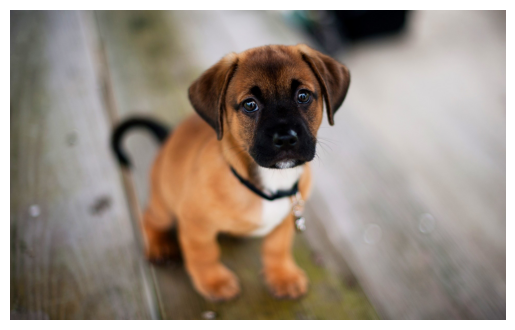

In [6]:
show_image("images/dog.jpg")


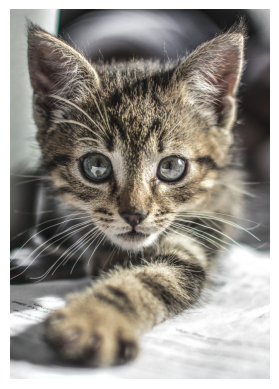

In [7]:
show_image("images/cat.jpg")


# Processing the inputs

Whilst these images are cute, they are not what the ML model expects. We need to process them to the correct size and format. We can use the `pre_trans` function to do this.

In [8]:
# first grab the pre-processing transform from the weights and send to the gpu
# unfortunatly the conv doesn't work on the mps device
if device != torch.device('mps') :
    pre_trans = weights.transforms().to(device) 
else :
    pre_trans = weights.transforms().to(torch.device('cpu') )

def load_and_process_image(file_path):
    # load image and send to the device
    if device != torch.device('mps') :
        image = tv_io.read_image(file_path).to(device) 
    else :
        image = tv_io.read_image(file_path).to(torch.device('cpu') )
    image = pre_trans(image)  
    image = image.unsqueeze(0) 
    return image.to(device)

processed_image_dog = load_and_process_image("images/dog.jpg")
print("Processed image shape: ", processed_image_dog.shape)

processed_image_cat = load_and_process_image("images/cat.jpg")
print("Processed image shape: ", processed_image_dog.shape)



Processed image shape:  torch.Size([1, 3, 224, 224])
Processed image shape:  torch.Size([1, 3, 224, 224])


Lets see how they look now. 

In [9]:

plot_image = F.to_pil_image(torch.squeeze(processed_image_cat))
plt.subplot(1, 2, 1)
plt.imshow(plot_image, cmap='gray')
plt.axis('off')
plt.title('Cat')
plt.subplot(1, 2, 2)
plot_image = F.to_pil_image(torch.squeeze(processed_image_dog))
plt.imshow(plot_image, cmap='gray')
plt.axis('off')
plt.title('Dog')
plt.show()



NameError: name 'F' is not defined

Not so cute now. The  strange colouring is due to the `Normalize` Transform, and the photo appears zoomed in because of `CenterCrop`.

## Using the Model

We can now use the model and make a prediction, as the output is very large (1000 classes) we need to get some way of knowing what the model is predicting. There are various version of this dataset classification online, in this case I have downloaded it in json format, which we can load easily in python.

In [40]:

vgg_classes = json.load(open("imagenet_class_index.json"))
for i in range(10) :
    print(f"{i} : {vgg_classes[str(i)]}")

0 : ['n01440764', 'tench']
1 : ['n01443537', 'goldfish']
2 : ['n01484850', 'great_white_shark']
3 : ['n01491361', 'tiger_shark']
4 : ['n01494475', 'hammerhead']
5 : ['n01496331', 'electric_ray']
6 : ['n01498041', 'stingray']
7 : ['n01514668', 'cock']
8 : ['n01514859', 'hen']
9 : ['n01518878', 'ostrich']


We can now write a function to read our predictions by passing in an image. 

In [47]:
def get_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    output = model(image)[0]  
    # Get top 3 predictions
    predictions = torch.topk(output, 3)
    indices = predictions.indices.tolist()
    # form a string from the top 3 predictions 
    out_str = "Results: "
    pred_classes = [vgg_classes[str(idx)][1] for idx in indices]
    out_str += ", ".join(pred_classes)
    print(out_str)

    return predictions

Results: Rhodesian_ridgeback, boxer, bull_mastiff


torch.return_types.topk(
values=tensor([10.8546, 10.6451, 10.0535], device='mps:0', grad_fn=<TopkBackward0>),
indices=tensor([159, 242, 243], device='mps:0'))

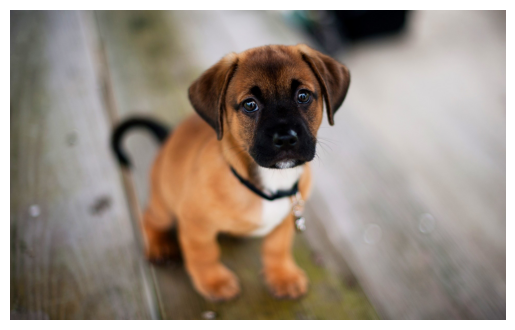

In [49]:
get_prediction("images/dog.jpg")

Results: tabby, tiger_cat, Egyptian_cat


torch.return_types.topk(
values=tensor([10.8802, 10.2199,  8.5038], device='mps:0', grad_fn=<TopkBackward0>),
indices=tensor([281, 282, 285], device='mps:0'))

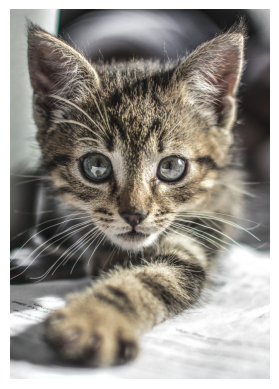

In [50]:
get_prediction("images/cat.jpg")

## Cat or Dog

We can now write a function to determine if we have a cat or dog, or something else.


In [63]:
def cat_or_dog(image_path):
    image = load_and_process_image(image_path)
    idx = model(image).argmax(dim=1).item()
    if 151 <= idx <= 268 or 281 <= idx <= 285 :
        print("cat or dog")
    else:
        print(f"Another animal which i thing is {vgg_classes[str(idx)][1]}")

In [58]:
cat_or_dog("images/dog.jpg")
cat_or_dog("images/cat.jpg")

cat or dog
cat or dog


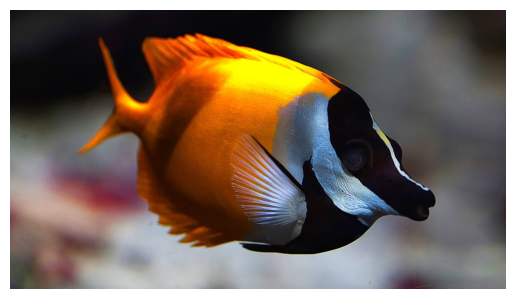

In [61]:
show_image("images/fish.jpg")

In [64]:
cat_or_dog("images/fish.jpg")


Another animal which i thing is macaw


ok so that guess is not close, but we can see that the model is working.

## Summary

So we have used a pre-trained model, in the next example we will train it on a new data set to specialize it.

Now we are finished let's clear the GPU cache.

In [ ]:
Utils.shutdown_kernel()

: 